# import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import torchvision
from torchsummary import summary

import time 
import copy
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_5008\403791658.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')
C:\Users\ayxan\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


# import data

In [2]:
data=torchvision.datasets.EMNIST(root='emnist',split='letters',download=False)

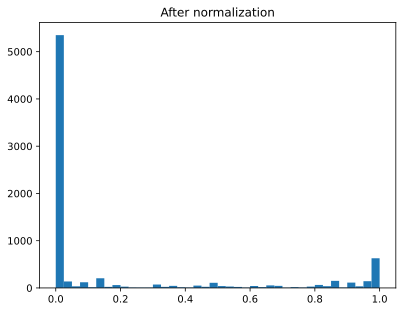

In [6]:
images=data.data.view([124800,1,28,28]).float()
images=images/torch.max(images)

labels=copy.deepcopy(data.targets)-1
letterCategor=data.classes[1:]
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After normalization')
plt.show()

In [137]:
train_data,devtest_data,train_label,devtest_label=train_test_split(
                                            images,labels,train_size=.9)

test_data,devol_data,test_label,devol_label=train_test_split(
                                        devtest_data,devtest_label,train_size=.9)

train_dataset=TensorDataset(train_data,train_label)
devol_dataset=TensorDataset(devol_data,devol_label)
test_dataset=TensorDataset(test_data,test_label)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True,drop_last=True)
devol_loader=DataLoader(devol_dataset,batch_size=devol_dataset.tensors[0].shape[0])
test_loader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


# cnn model

In [146]:
def createModel(printSize=False):
    
    class Model(nn.Module):
        def __init__(self,printSize):
            super().__init__()
            
            self.print=printSize
            
            inChan=1
            secChan=15
            thirChan=65
            fourChan=260
            thelastSize=2
            
            # convolution layers
            self.conv1=nn.Conv2d(inChan,secChan,5,1,1)
            self.bNorm1=nn.BatchNorm2d(secChan)
            
            self.conv2=nn.Conv2d(secChan,thirChan,3,1,1)
            self.bNorm2=nn.BatchNorm2d(thirChan)
            
            self.conv3=nn.Conv2d(thirChan,fourChan,3,1,1)
            self.bNorm3=nn.BatchNorm2d(fourChan)
            # linear layers
            self.expectedSize=thelastSize*thelastSize*fourChan
            
            self.fc1=nn.Linear(self.expectedSize,250)            
            self.fc2=nn.Linear(250,50)
            self.out=nn.Linear(50,26)
            
        def forward(self,x):
            if self.print: print(f'input : {list(x.shape)}')
            
            x=F.max_pool2d( self.conv1(x),3,2,1)
            x=F.leaky_relu( self.bNorm1(x))
#             x=F.dropout(x,p=.15,training=self.training)
            if self.print: print(f'first cnn layer : {list(x.shape)}')
                   
            x=F.max_pool2d( self.conv2(x),5,2,1)
            x=F.leaky_relu( self.bNorm2(x))
#             x=F.dropout(x,p=.15,training=self.training)
            if self.print: print(f'second cnn layer : {list(x.shape)}')
            
            x=F.max_pool2d( self.conv3(x),5,2,1)
            x=F.leaky_relu(self.bNorm3(x))
#             x=F.dropout(x,p=.15,training=self.training)
            if self.print: print(f'third cnn layer : {list(x.shape)}')
                
            x=x.view(-1,int(self.expectedSize))
            if self.print: print(f'Vectorized: {list(x.shape)}')
                
            x=F.leaky_relu( self.fc1(x))
#             x=F.dropout(x,p=.3,training=self.training)
            x=F.leaky_relu(self.fc2(x))
#             x=F.dropout(x,p=.3,training=self.training)
            x=self.out(x)
            if self.print: print(f'Final output: {list(x.shape)}')

            return x
        
    cnn=Model(printSize)
    
    lossfun=nn.CrossEntropyLoss()
    
    optimizer=torch.optim.Adam(cnn.parameters(),lr=.001)
    
    return cnn,lossfun,optimizer

In [144]:
# test the model with one batch
cnn,lossfun,optimizer = createModel(True)

X,y = next(iter(train_loader))
yHat = cnn(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

input : [64, 1, 28, 28]
first cnn layer : [64, 15, 13, 13]
second cnn layer : [64, 65, 6, 6]
third cnn layer : [64, 260, 2, 2]
Vectorized: [64, 1040]
Final output: [64, 26]

Output size:
torch.Size([64, 26])
 
Loss:
tensor(3.2821, grad_fn=<NllLossBackward0>)


In [136]:
summary(cnn,(1,28,28))

input : [2, 1, 28, 28]
first cnn layer : [2, 10, 13, 13]
second cnn layer : [2, 30, 6, 6]
third cnn layer : [2, 65, 2, 2]
Vectorized: [2, 260]
Final output: [2, 26]
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─BatchNorm2d: 1-2                       [-1, 10, 13, 13]          20
├─Conv2d: 1-3                            [-1, 30, 13, 13]          2,730
├─BatchNorm2d: 1-4                       [-1, 30, 6, 6]            60
├─Conv2d: 1-5                            [-1, 65, 6, 6]            17,615
├─BatchNorm2d: 1-6                       [-1, 65, 2, 2]            130
├─Linear: 1-7                            [-1, 250]                 65,250
├─Linear: 1-8                            [-1, 50]                  12,550
├─Linear: 1-9                            [-1, 26]                  1,326
Total params: 99,941
Trainable params: 99,941
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─BatchNorm2d: 1-2                       [-1, 10, 13, 13]          20
├─Conv2d: 1-3                            [-1, 30, 13, 13]          2,730
├─BatchNorm2d: 1-4                       [-1, 30, 6, 6]            60
├─Conv2d: 1-5                            [-1, 65, 6, 6]            17,615
├─BatchNorm2d: 1-6                       [-1, 65, 2, 2]            130
├─Linear: 1-7                            [-1, 250]                 65,250
├─Linear: 1-8                            [-1, 50]                  12,550
├─Linear: 1-9                            [-1, 26]                  1,326
Total params: 99,941
Trainable params: 99,941
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.38
Estimated Total Size (MB): 0.52

# model training

In [52]:
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [60]:
def trainModel(Numepoch=10):
    cnn,lossfun,optimizer = createModel(False)
    
    trainLoss=torch.zeros(Numepoch)
    devolLoss=torch.zeros(Numepoch)
    trainErr=[]
    devolErr=[]
    trainAcc=[]
    devolAcc=[]
    cnn.to(device)
    
    for epoch in range(Numepoch):
        batchLoss=[]
        batchErr=[]
        batchAcc=[]
        cnn.train()
        
        for dat,lab in train_loader:
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=cnn(dat)
            loss=lossfun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            lab=lab.cpu()
            yHat=yHat.cpu()
            match=(torch.argmax(yHat,axis=1)!=lab).float()
            batchErr.append(100*torch.mean(match).item())
            match=(torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*torch.mean(match).item())
        
        trainLoss[epoch]=np.mean(batchLoss)
        trainErr.append(np.mean(batchErr))
        trainAcc.append(np.mean(batchAcc))
        
        cnn.eval()
        dat,lab=next(iter(devol_loader))
        dat=dat.to(device)
        lab=lab.to(device)
        if torch.no_grad():
            yHat=cnn(dat)
            loss=lossfun(yHat,lab)
            
        yHat=yHat.cpu()
        lab=lab.cpu()
        devolLoss[epoch]=loss.item()
        match=(torch.argmax(yHat,axis=1)!=lab).float()
        devolErr.append(100*torch.mean(match).item())
        
        match=(torch.argmax(yHat,axis=1)==lab).float()
        devolAcc.append(100*torch.mean(match).item())
    cnn.cpu()
    return  cnn,trainLoss,trainErr,trainAcc,devolLoss,devolErr,devolAcc

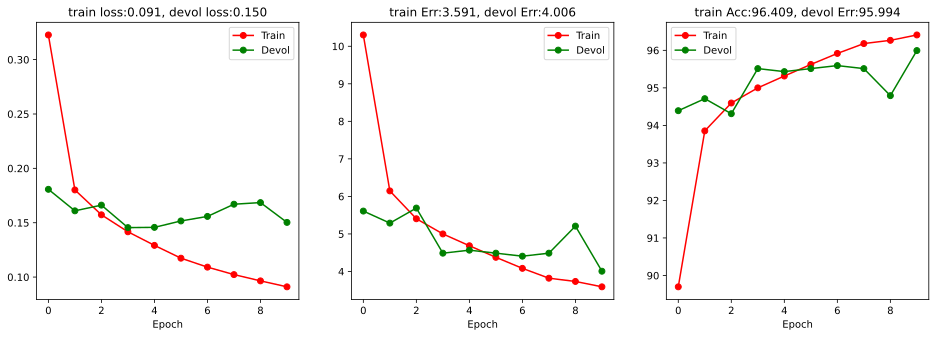

In [147]:
cnn,trainLoss,trainErr,trainAcc,devolLoss,devolErr,devolAcc=trainModel(10)
fig,ax=plt.subplots(1,3,figsize=(16,5))
ax[0].plot(trainLoss,'ro-',label='Train')
ax[0].plot(devolLoss,'go-',label='Devol')
ax[0].set_xlabel('Epoch')
ax[0].set_title(f'train loss:{trainLoss[-1]:.3f}, devol loss:{devolLoss[-1]:.3f}')
ax[0].legend()

ax[1].plot(trainErr,'ro-',label='Train')
ax[1].plot(devolErr,'go-',label='Devol')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'train Err:{trainErr[-1]:.3f}, devol Err:{devolErr[-1]:.3f}')
ax[1].legend()

ax[2].plot(trainAcc,'ro-',label='Train')
ax[2].plot(devolAcc,'go-',label='Devol')
ax[2].set_xlabel('Epoch')
ax[2].set_title(f'train Acc:{trainAcc[-1]:.3f}, devol Err:{devolAcc[-1]:.3f}')
ax[2].legend()

# model save

In [148]:
torch.save(cnn.state_dict(),'emnistClassif.pt')

# model testing

In [160]:
model=createModel()[0]
model.load_state_dict(torch.load('emnistClassif.pt'))
model.to(device)

Model(
  (conv1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bNorm1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(15, 65, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bNorm2): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(65, 260, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bNorm3): BatchNorm2d(260, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1040, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=26, bias=True)
)

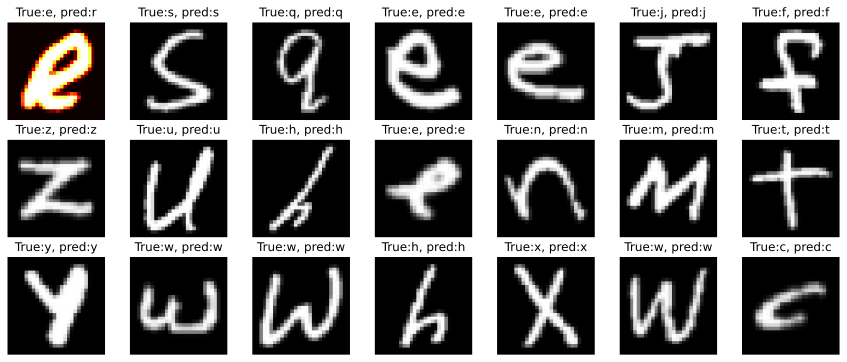

In [161]:
dat,lab=next(iter(test_loader))
dat=dat.to(device)
yHat=model(dat)
indexs=np.random.choice(len(lab),size=21,replace=False)
dat=dat.cpu()

fig,axs=plt.subplots(3,7,figsize=(15,6))
for i,ax in enumerate(axs.flatten()):
    img=torch.squeeze(dat[indexs[i],0,:,:]).detach()
    true=letterCategor[ lab[indexs[i]] ]
    pred=letterCategor[torch.argmax(yHat[indexs[i],:])]
    
    col='gray' if true==pred else 'hot'
    ax.imshow(img.T,cmap=col)
    ax.set_title(f'True:{true}, pred:{pred}')
    ax.axis('off')

# confusion matrix

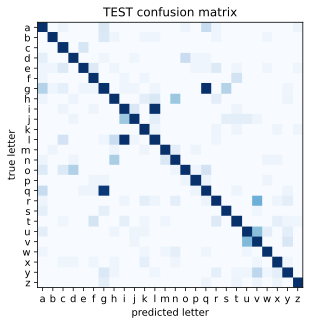

In [157]:
ConMat=skm.confusion_matrix(lab,torch.argmax(yHat,axis=1),normalize='true')

plt.imshow(ConMat,'Blues',vmax=.05)
plt.xticks(range(26),labels=letterCategor)
plt.yticks(range(26),labels=letterCategor)
plt.title('TEST confusion matrix')
plt.ylabel('true letter')
plt.xlabel('predicted letter')
plt.show()